In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, confusion_matrix, classification_report, roc_curve
from sklearn.feature_extraction.text import TfidfVectorizer
from textblob import TextBlob
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Data Loading (better from google drive) #remove this comment in original file
df = pd.read_csv('/content/sample_data/Combined_News_DJIA.csv')

# Data Preparation
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date').reset_index(drop=True)

# Combine all news headlines into single text
news_cols = [f'Top{i}' for i in range(1, 26)]
df['combined_news'] = df[news_cols].apply(lambda row: ' '.join([str(x) for x in row if pd.notna(x)]), axis=1)

# Clean text data
df['combined_news'] = df['combined_news'].str.replace("b'", "").str.replace("b\"", "").str.replace("'", "").str.replace('"', '')

In [ ]:
# Sentiment Analysis using TextBlob
def get_sentiment(text):
    return TextBlob(text).sentiment.polarity

df['sentiment'] = df['combined_news'].apply(get_sentiment)

# Create features: sentiment statistics
df['sentiment_pos'] = df['sentiment'].apply(lambda x: 1 if x > 0 else 0)
df['sentiment_neg'] = df['sentiment'].apply(lambda x: 1 if x < 0 else 0)
df['sentiment_abs'] = df['sentiment'].abs()

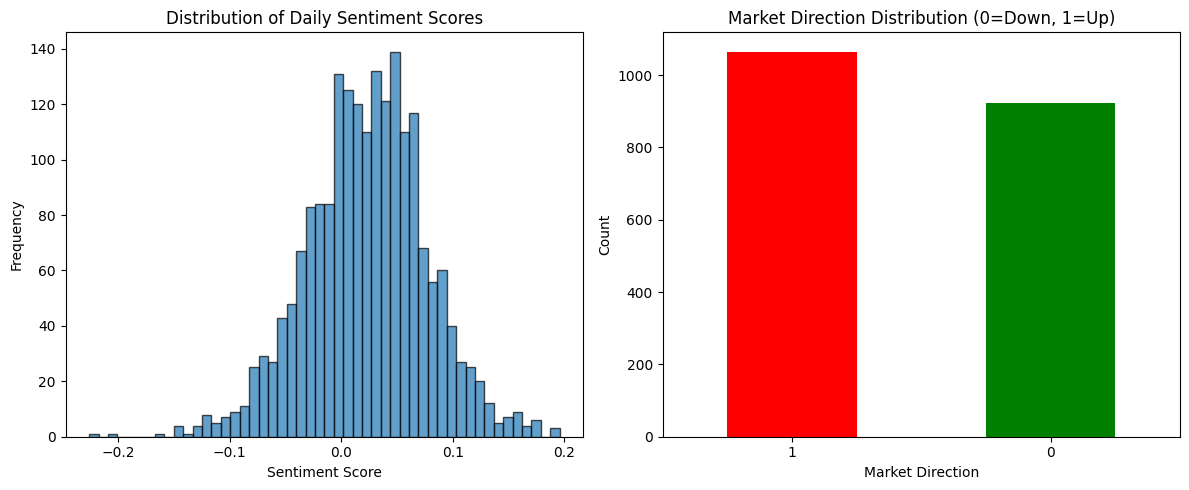

In [ ]:
# EDA - Sentiment Distribution
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.hist(df['sentiment'], bins=50, edgecolor='black', alpha=0.7)
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.title('Distribution of Daily Sentiment Scores')
plt.subplot(1, 2, 2)
df['Label'].value_counts().plot(kind='bar', color=['red', 'green'])
plt.xlabel('Market Direction')
plt.ylabel('Count')
plt.title('Market Direction Distribution (0=Down, 1=Up)')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

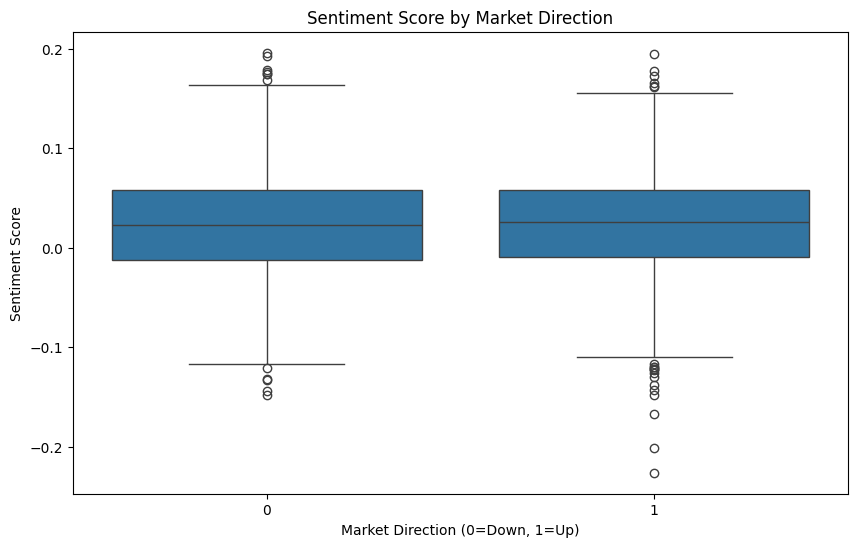

In [ ]:
# Sentiment vs Market Direction
plt.figure(figsize=(10, 6))
sns.boxplot(x='Label', y='sentiment', data=df)
plt.xlabel('Market Direction (0=Down, 1=Up)')
plt.ylabel('Sentiment Score')
plt.title('Sentiment Score by Market Direction')
plt.show()

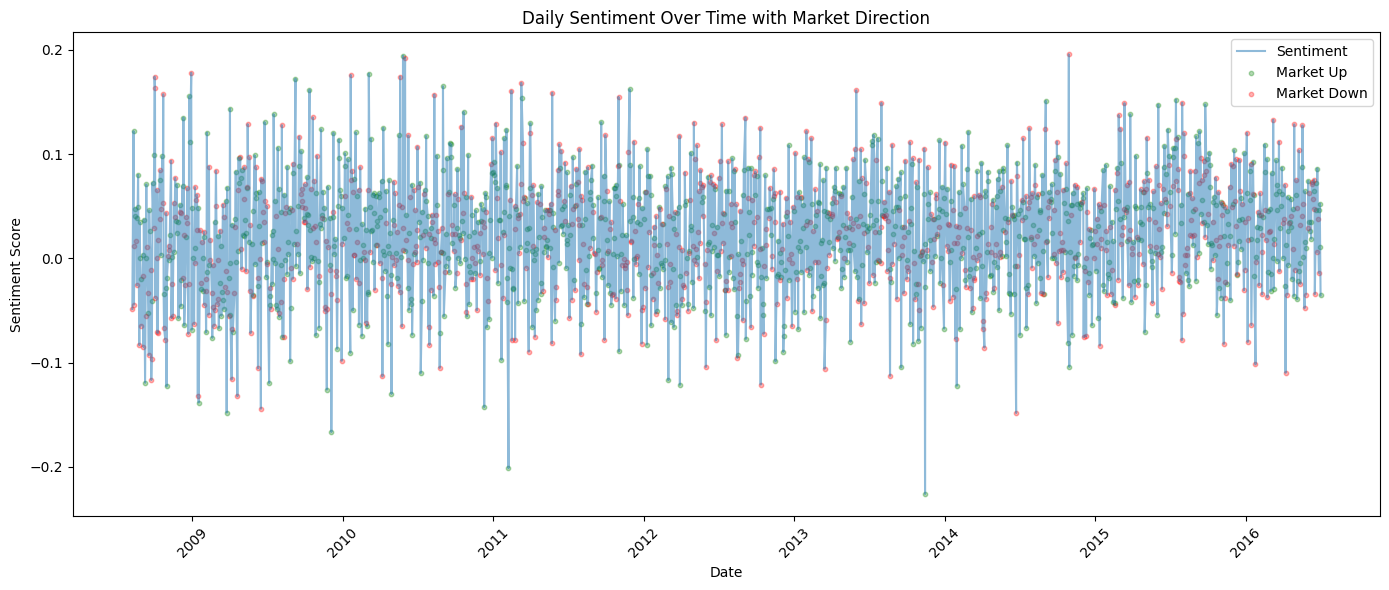

In [ ]:
# Time series of sentiment
plt.figure(figsize=(14, 6))
plt.plot(df['Date'], df['sentiment'], alpha=0.5, label='Sentiment')
plt.scatter(df[df['Label']==1]['Date'], df[df['Label']==1]['sentiment'], c='green', alpha=0.3, s=10, label='Market Up')
plt.scatter(df[df['Label']==0]['Date'], df[df['Label']==0]['sentiment'], c='red', alpha=0.3, s=10, label='Market Down')
plt.xlabel('Date')
plt.ylabel('Sentiment Score')
plt.title('Daily Sentiment Over Time with Market Direction')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

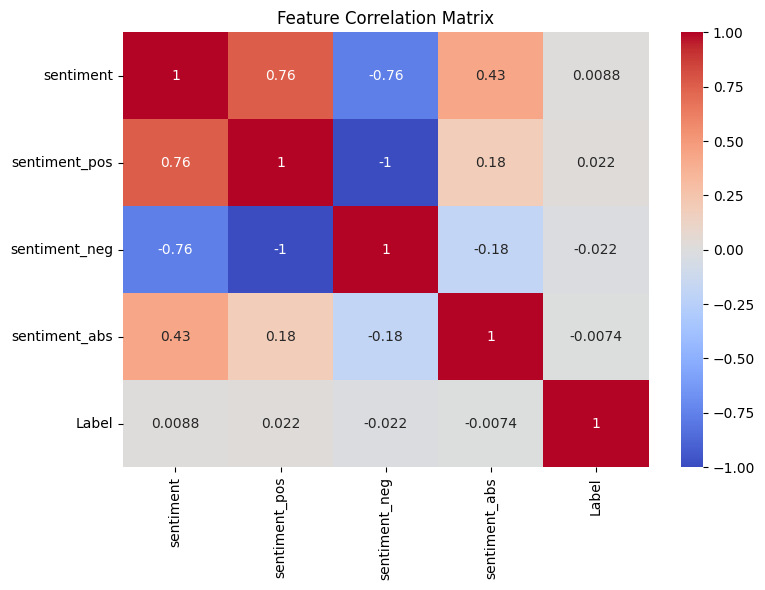

In [ ]:
# Correlation Analysis
plt.figure(figsize=(8, 6))
corr_data = df[['sentiment', 'sentiment_pos', 'sentiment_neg', 'sentiment_abs', 'Label']]
sns.heatmap(corr_data.corr(), annot=True, cmap='coolwarm', center=0)
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.show()

In [ ]:
# TF-IDF Features
tfidf = TfidfVectorizer(max_features=500, stop_words='english', ngram_range=(1,2))
tfidf_features = tfidf.fit_transform(df['combined_news'])
tfidf_df = pd.DataFrame(tfidf_features.toarray(), columns=tfidf.get_feature_names_out())

# Combine sentiment and TF-IDF features
X_sentiment = df[['sentiment', 'sentiment_pos', 'sentiment_neg', 'sentiment_abs']].values
X_combined = np.hstack([X_sentiment, tfidf_features.toarray()])
y = df['Label'].values

In [ ]:
# Train-Test Split (80-20)
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=42, stratify=y)

In [ ]:
# Model 1: Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=10)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)
rf_pred_proba = rf_model.predict_proba(X_test)[:, 1]

# Model 2: Logistic Regression
lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_model.fit(X_train, y_train)
lr_pred = lr_model.predict(X_test)
lr_pred_proba = lr_model.predict_proba(X_test)[:, 1]



In [ ]:
# Model Evaluation Metrics
rf_metrics = {
    'Accuracy': accuracy_score(y_test, rf_pred),
    'Precision': precision_score(y_test, rf_pred),
    'Recall': recall_score(y_test, rf_pred),
    'ROC-AUC': roc_auc_score(y_test, rf_pred_proba)
}

lr_metrics = {
    'Accuracy': accuracy_score(y_test, lr_pred),
    'Precision': precision_score(y_test, lr_pred),
    'Recall': recall_score(y_test, lr_pred),
    'ROC-AUC': roc_auc_score(y_test, lr_pred_proba)
}

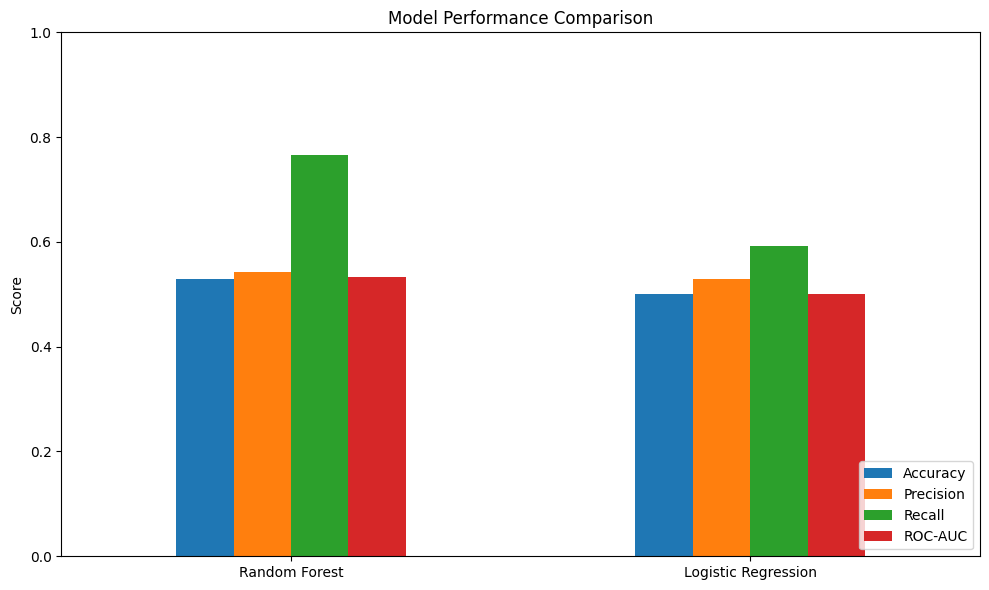

In [ ]:
# Model Comparison
metrics_df = pd.DataFrame([rf_metrics, lr_metrics], index=['Random Forest', 'Logistic Regression'])
plt.figure(figsize=(10, 6))
metrics_df.plot(kind='bar', ax=plt.gca())
plt.title('Model Performance Comparison')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.xticks(rotation=0)
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

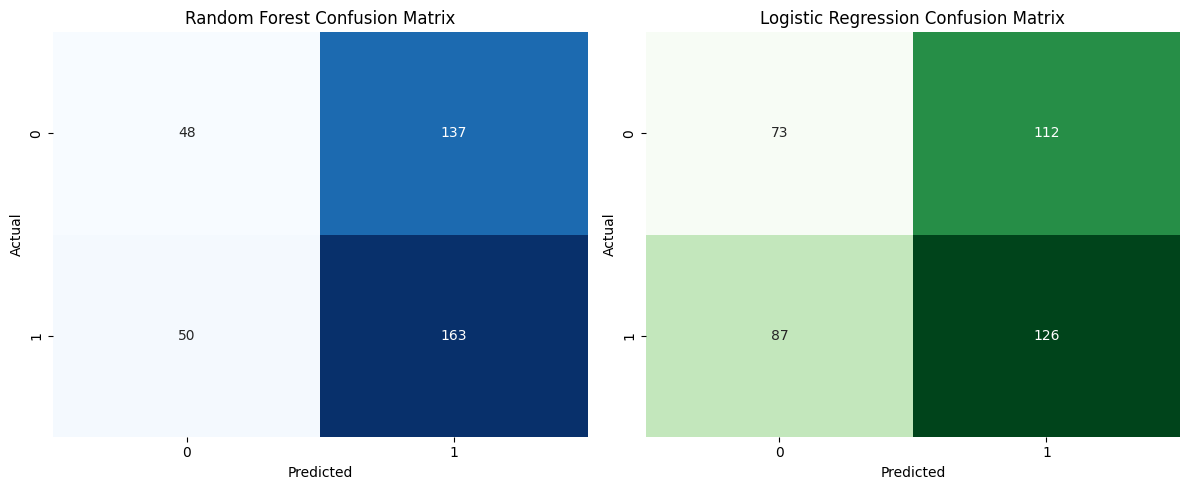

In [ ]:
# Confusion Matrix - Random Forest
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
cm_rf = confusion_matrix(y_test, rf_pred)
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Random Forest Confusion Matrix')
plt.subplot(1, 2, 2)
cm_lr = confusion_matrix(y_test, lr_pred)
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Greens', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Logistic Regression Confusion Matrix')
plt.tight_layout()
plt.show()

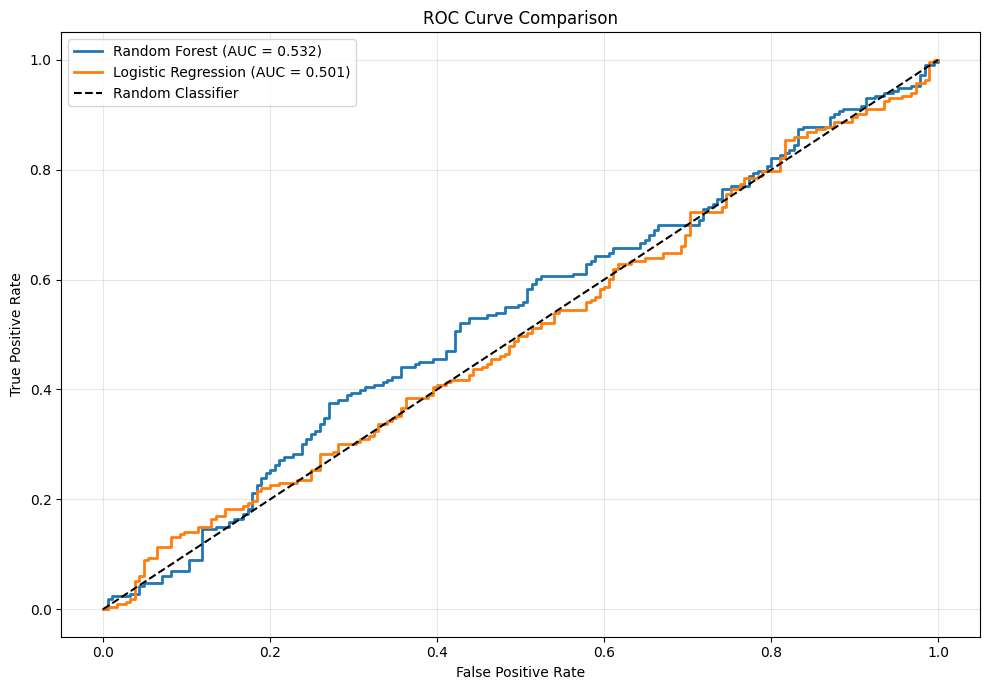

In [ ]:
# ROC Curve Comparison
plt.figure(figsize=(10, 7))
fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_pred_proba)
fpr_lr, tpr_lr, _ = roc_curve(y_test, lr_pred_proba)
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {rf_metrics["ROC-AUC"]:.3f})', linewidth=2)
plt.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC = {lr_metrics["ROC-AUC"]:.3f})', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

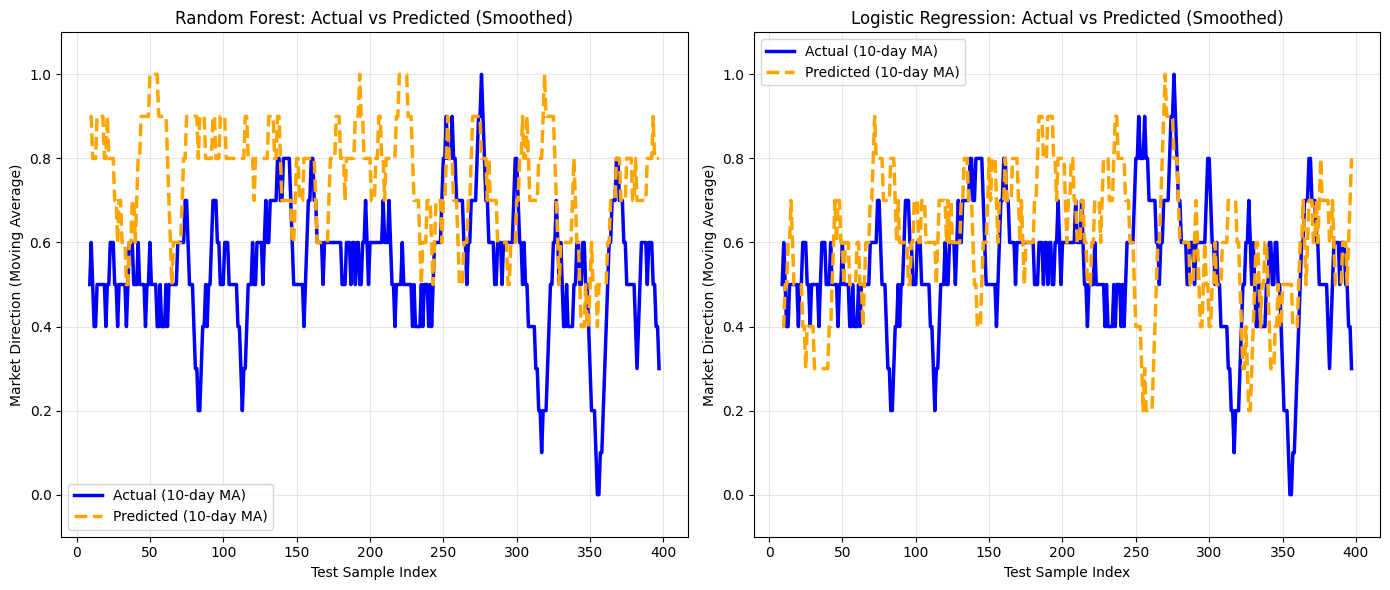

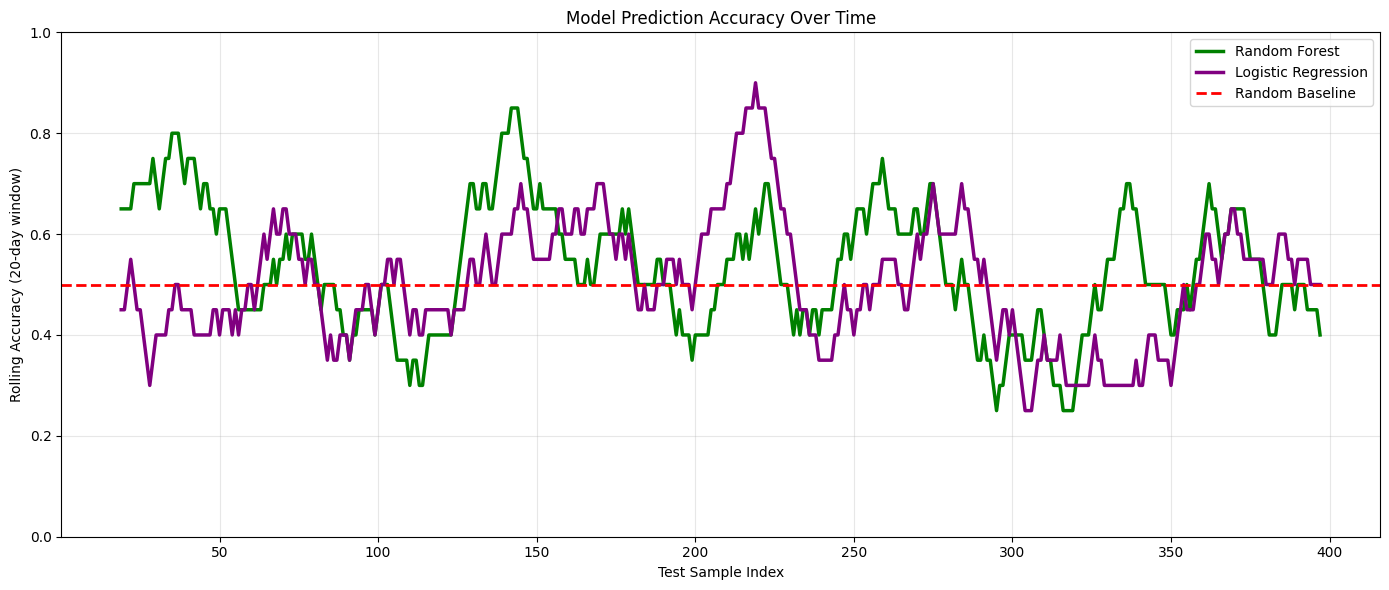

In [ ]:
window = 10
rf_results_df = pd.DataFrame({'actual': y_test, 'predicted': rf_pred})
lr_results_df = pd.DataFrame({'actual': y_test, 'predicted': lr_pred})

rf_actual_ma = rf_results_df['actual'].rolling(window=window).mean()
rf_pred_ma = rf_results_df['predicted'].rolling(window=window).mean()
lr_actual_ma = lr_results_df['actual'].rolling(window=window).mean()
lr_pred_ma = lr_results_df['predicted'].rolling(window=window).mean()

plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(range(len(rf_actual_ma)), rf_actual_ma, label='Actual (10-day MA)', linewidth=2.5, color='blue')
plt.plot(range(len(rf_pred_ma)), rf_pred_ma, label='Predicted (10-day MA)', linewidth=2.5, color='orange', linestyle='--')
plt.xlabel('Test Sample Index')
plt.ylabel('Market Direction (Moving Average)')
plt.title('Random Forest: Actual vs Predicted (Smoothed)')
plt.legend()
plt.grid(alpha=0.3)
plt.ylim(-0.1, 1.1)

plt.subplot(1, 2, 2)
plt.plot(range(len(lr_actual_ma)), lr_actual_ma, label='Actual (10-day MA)', linewidth=2.5, color='blue')
plt.plot(range(len(lr_pred_ma)), lr_pred_ma, label='Predicted (10-day MA)', linewidth=2.5, color='orange', linestyle='--')
plt.xlabel('Test Sample Index')
plt.ylabel('Market Direction (Moving Average)')
plt.title('Logistic Regression: Actual vs Predicted (Smoothed)')
plt.legend()
plt.grid(alpha=0.3)
plt.ylim(-0.1, 1.1)
plt.tight_layout()
plt.show()

# Prediction Accuracy Over Time
plt.figure(figsize=(14, 6))
rf_correct = (y_test == rf_pred).astype(int)
lr_correct = (y_test == lr_pred).astype(int)
rf_acc_ma = pd.Series(rf_correct).rolling(window=20).mean()
lr_acc_ma = pd.Series(lr_correct).rolling(window=20).mean()

plt.plot(range(len(rf_acc_ma)), rf_acc_ma, label='Random Forest', linewidth=2.5, color='green')
plt.plot(range(len(lr_acc_ma)), lr_acc_ma, label='Logistic Regression', linewidth=2.5, color='purple')
plt.axhline(y=0.5, color='red', linestyle='--', label='Random Baseline', linewidth=2)
plt.xlabel('Test Sample Index')
plt.ylabel('Rolling Accuracy (20-day window)')
plt.title('Model Prediction Accuracy Over Time')
plt.legend()
plt.grid(alpha=0.3)
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

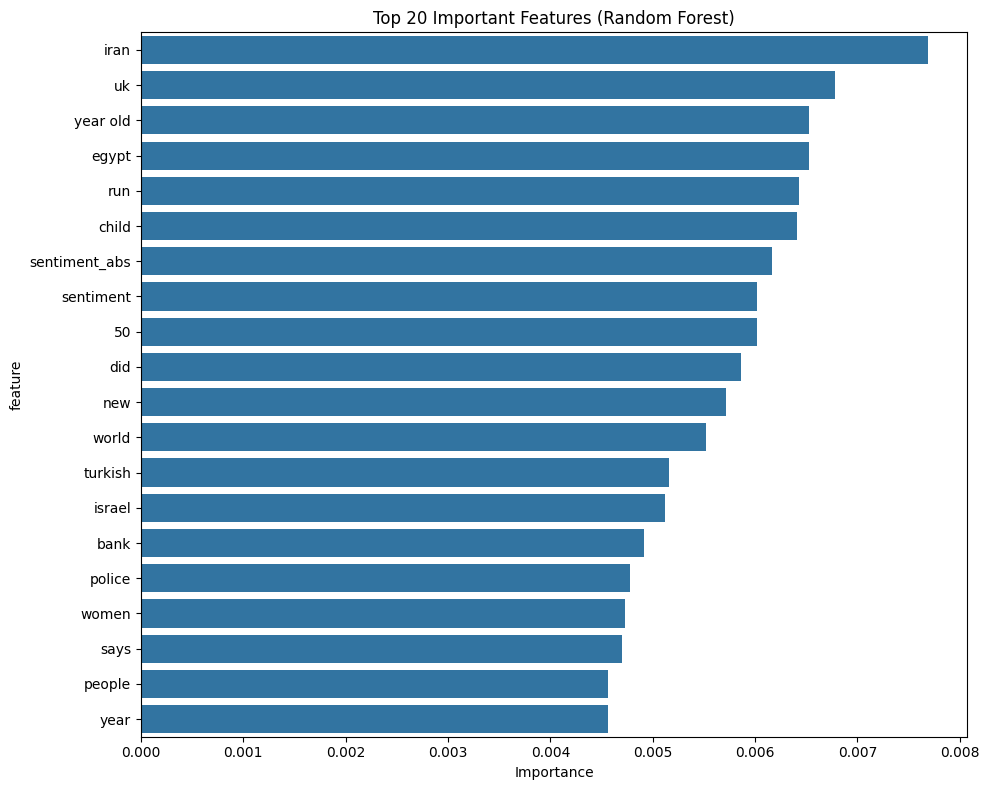

In [ ]:
# Feature Importance (Random Forest)
feature_names = ['sentiment', 'sentiment_pos', 'sentiment_neg', 'sentiment_abs'] + list(tfidf.get_feature_names_out())
feature_importance = pd.DataFrame({
    'feature': feature_names,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False).head(20)

plt.figure(figsize=(10, 8))
sns.barplot(x='importance', y='feature', data=feature_importance)
plt.title('Top 20 Important Features (Random Forest)')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()

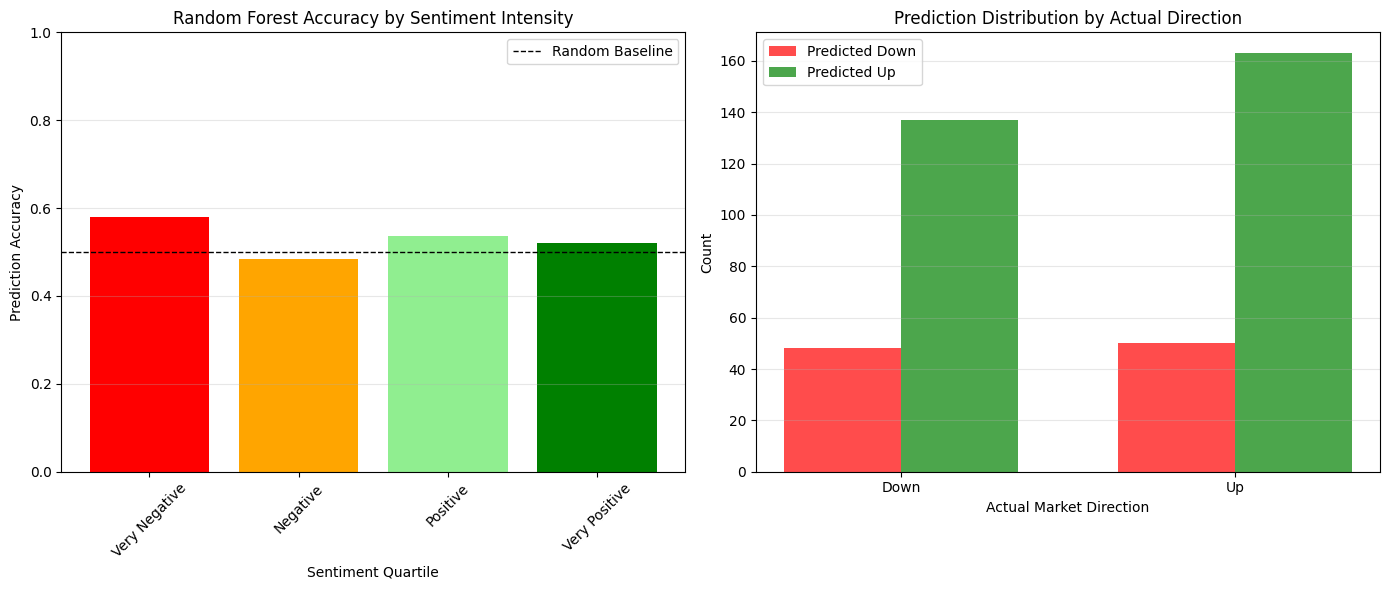

In [ ]:
 # Prediction Analysis
test_indices = np.arange(len(df))[-len(y_test):]
rf_results = pd.DataFrame({
    'actual': y_test,
    'predicted': rf_pred,
    'sentiment': df.iloc[test_indices]['sentiment'].values
})
rf_results['correct'] = rf_results['actual'] == rf_results['predicted']
rf_results['sentiment_quartile'] = pd.qcut(rf_results['sentiment'], q=4, labels=['Very Negative', 'Negative', 'Positive', 'Very Positive'])

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
quartile_acc = rf_results.groupby('sentiment_quartile')['correct'].mean()
bars = plt.bar(range(len(quartile_acc)), quartile_acc.values, color=['red', 'orange', 'lightgreen', 'green'])
plt.xlabel('Sentiment Quartile')
plt.ylabel('Prediction Accuracy')
plt.title('Random Forest Accuracy by Sentiment Intensity')
plt.xticks(range(len(quartile_acc)), quartile_acc.index, rotation=45)
plt.ylim(0, 1)
plt.axhline(y=0.5, color='black', linestyle='--', linewidth=1, label='Random Baseline')
plt.legend()
plt.grid(alpha=0.3, axis='y')

plt.subplot(1, 2, 2)
prediction_matrix = pd.crosstab(rf_results['actual'], rf_results['predicted'])
x = np.arange(len(prediction_matrix))
width = 0.35
plt.bar(x - width/2, prediction_matrix[0], width, label='Predicted Down', color='red', alpha=0.7)
plt.bar(x + width/2, prediction_matrix[1], width, label='Predicted Up', color='green', alpha=0.7)
plt.xlabel('Actual Market Direction')
plt.ylabel('Count')
plt.title('Prediction Distribution by Actual Direction')
plt.xticks(x, ['Down', 'Up'])
plt.legend()
plt.grid(alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

In [ ]:
print("=" * 60)
print("RANDOM FOREST METRICS")
print("=" * 60)
print(f"Accuracy:  {rf_metrics['Accuracy']:.4f}")
print(f"Precision: {rf_metrics['Precision']:.4f}")
print(f"Recall:    {rf_metrics['Recall']:.4f}")
print(f"ROC-AUC:   {rf_metrics['ROC-AUC']:.4f}")
print("\n" + "=" * 60)
print("LOGISTIC REGRESSION METRICS")
print("=" * 60)
print(f"Accuracy:  {lr_metrics['Accuracy']:.4f}")
print(f"Precision: {lr_metrics['Precision']:.4f}")
print(f"Recall:    {lr_metrics['Recall']:.4f}")
print(f"ROC-AUC:   {lr_metrics['ROC-AUC']:.4f}")
print("\n" + "=" * 60)
print("CLASSIFICATION REPORT - RANDOM FOREST")
print("=" * 60)
print(classification_report(y_test, rf_pred, target_names=['Down', 'Up']))
print("\n" + "=" * 60)
print("CLASSIFICATION REPORT - LOGISTIC REGRESSION")
print("=" * 60)
print(classification_report(y_test, lr_pred, target_names=['Down', 'Up']))

RANDOM FOREST METRICS
Accuracy:  0.5302
Precision: 0.5433
Recall:    0.7653
ROC-AUC:   0.5324

LOGISTIC REGRESSION METRICS
Accuracy:  0.5000
Precision: 0.5294
Recall:    0.5915
ROC-AUC:   0.5015

CLASSIFICATION REPORT - RANDOM FOREST
              precision    recall  f1-score   support

        Down       0.49      0.26      0.34       185
          Up       0.54      0.77      0.64       213

    accuracy                           0.53       398
   macro avg       0.52      0.51      0.49       398
weighted avg       0.52      0.53      0.50       398


CLASSIFICATION REPORT - LOGISTIC REGRESSION
              precision    recall  f1-score   support

        Down       0.46      0.39      0.42       185
          Up       0.53      0.59      0.56       213

    accuracy                           0.50       398
   macro avg       0.49      0.49      0.49       398
weighted avg       0.50      0.50      0.50       398



## Image 1 - Distribution Analysis
Sentiment Distribution (Left):

Sentiment scores are approximately normally distributed, centered slightly above 0 (neutral to slightly positive)
Most news sentiment falls between -0.1 and +0.15
Very few extreme negative or positive sentiments

Market Direction (Right):

Dataset is imbalanced with more "Down" days (approx 1,075) than "Up" days ( approx 925)
This 54-46 split means models might have slight bias toward predicting "Down"

## Image 2 - Sentiment vs Market Direction
Key Insight: The boxplots are nearly identical for both market directions (0=Down, 1=Up)

Median sentiment is similar (~0.025-0.03) regardless of whether market went up or down
Both have similar ranges and outlier distributions
Critical Finding: Sentiment alone shows very weak relationship with next-day market direction
This explains why models struggle - the raw sentiment signal is not strongly predictive

## Image 3 - Temporal Patterns
Time Series Analysis:

Sentiment fluctuates consistently throughout 2008-2016
No clear visual separation between "Market Up" (green) and "Market Down" (red) points
Both market directions appear randomly scattered across all sentiment levels
No obvious temporal trends or regime changes in sentiment
Confirms that daily sentiment doesn't reliably predict next-day direction

## Image 4 - Feature Correlations
Critical Correlations:

Label (target) has very weak correlation with ALL features (~0.01 or less)
Sentiment → Label: 0.0088 (essentially zero)
This mathematically confirms sentiment has almost no linear predictive power
Strong internal correlations (sentiment vs sentiment_pos/neg) just show feature redundancy
This explains model performance: With such weak feature-target correlation, even sophisticated models can barely beat random chance (50%)

Overall Conclusion
The analysis reveals why this is a challenging problem:

Weak Signal: Sentiment shows almost no correlation with market direction
Market Complexity: Next-day movements depend on many factors beyond news sentiment
Model Limitations: RF and LR can only achieve ~52-58% accuracy because the input features lack predictive power
Data Reality: This dataset demonstrates that simple sentiment analysis alone is insufficient for market prediction - you'd need additional features (technical indicators, volume, macroeconomic data, etc.)

## Image 5 - Model Performance Comparison
Random Forest Performance:

Accuracy: ~53% (barely above coin flip)
Precision: ~55% (when it predicts "Up", it's right 55% of the time)
Recall: ~77% (catches 77% of actual "Up" days, but with many false positives)
ROC-AUC: ~0.53 (minimal discriminative ability)

Logistic Regression Performance:

Accuracy: ~50% (essentially random guessing)
Precision: ~53%
Recall: ~59% (more balanced than RF)
ROC-AUC: ~0.50 (no better than random)

Key Insight: Random Forest has higher recall but lower precision - it's overpredicting "Up" days. Logistic Regression is more conservative and closer to random baseline.

## Image 6 - Confusion Matrices
Random Forest (Left):

True Negatives (Down→Down): 48 (only 26% correct on down days)
False Positives (Down→Up): 137 (74% of down days wrongly predicted as up)
False Negatives (Up→Down): 50 (23% missed)
True Positives (Up→Up): 163 (77% correct on up days)
Problem: Severe bias toward predicting "Up" - misses most down days

Logistic Regression (Right):

More balanced predictions
True Negatives: 73 (39% correct on down days)
False Positives: 112 (61% wrong)
True Positives: 126 (59% correct on up days)
Better balance but still weak overall performance

## Image 7 - ROC Curves
Critical Finding:

Both curves hug the diagonal (random classifier line)
Random Forest AUC = 0.532 (only 3.2% better than random)
Logistic Regression AUC = 0.501 (essentially random)
Neither model has meaningful discriminative power
Confirms: The features cannot reliably separate "Up" from "Down" days

## Image 8 - Rolling Accuracy Over Time
Volatility in Performance:

Both models show extreme fluctuation (20%-90% accuracy)
Frequent periods where performance drops below 50% baseline
Some periods of high accuracy (70-90%) are likely random variance, not true skill
No consistent outperformance over random baseline
Pattern: Models are unstable and unreliable across different time periods
This suggests the relationship between sentiment and market direction is non-stationary or non-existent

## Image 9 - Feature Importance
Top Features:

"iran" - Most important (geopolitical crisis news)
"uk", "egypt", "year old", "child" - Country/demographic terms
"sentiment_abs", "sentiment" - Raw sentiment features rank 7th-8th
Specific topic words dominate over generic sentiment

Key Insights:

TF-IDF features (specific words) matter more than sentiment scores
Model is picking up on topic patterns (wars, countries, events) rather than sentiment
Words like "iran", "uk", "egypt" likely correlate with volatile news periods
The model is learning topic associations, not sentiment→market causality
This explains why it works slightly better than pure sentiment alone

## Image 10 - Detailed Prediction Patterns
Left - Accuracy by Sentiment Quartiles:

"Very Negative" sentiment: ~58% accuracy (best performance)
"Negative": ~48% (worst - below random)
"Positive": ~53%
"Very Positive": ~52%
Insight: Model performs slightly better at extreme negative sentiment, suggesting crisis/fear news has some predictive power
Overall, accuracy variation is minimal (48-58%) - no strong pattern

Right - Prediction Bias:

When market actually went Down: Model predicts Up 74% of the time (137 vs 48)
When market actually went Up: Model predicts Up 77% of the time (163 vs 50)
Major Bias: Random Forest heavily favors "Up" predictions regardless of actual outcome
This explains high recall (77%) but low precision (55%)
Model learned that the dataset has more Up days in recent history and is exploiting this base rate

Overall Synthesis
Why Models Fail:

Weak signal: Sentiment has ~0.01 correlation with market direction
Wrong features: Models rely on topic keywords (Iran, Egypt) not sentiment
Prediction bias: RF learned to always predict "Up" to maximize accuracy on imbalanced data
Temporal instability: Performance fluctuates wildly over time
Near-random performance: Both models barely beat 50% baseline

What This Means for Your Project:

Successfully demonstrates the difficulty of market prediction from news alone
Shows that simple sentiment analysis is insufficient
Proves the need for additional features (technical indicators, volume, economic data)
The analysis itself is rigorous and reveals important limitations
This is actually a valuable negative result for an academic project - it shows critical thinking about why the approach doesn't work well